# PCS5024 - Aprendizado Estatístico - Statistical Learning - 2023/1
## Professors: 
 - Anna Helena Reali Costa (anna.reali@usp.br)
 - Fabio G. Cozman (fgcozman@usp.br)
## Student: 
 - Caio Azevedo - (caio.aze@alumni.usp.br)

# New section

In [1]:
!pip install --quiet torch numpy pandas gdown uniplot matplotlib

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
import gdown
from tqdm import tqdm
import uniplot
import datetime
import random

# Recurrent Neural Networks

Recurrent Neural Networks (RNNs) is a family of neural network specifically designed for processing sequential data (Rumelhart et al., 1986a). They can handle sequences of variable length and share parameters across different parts of the model, making them more adaptable to different input forms. RNNs can generalize across different sequence lengths and positions in time, which is particularly important when specific information can occur at multiple positions within a sequence.

In contrast to traditional fully connected feedforward networks, RNNs share the same weights across several time steps. This allows the network to learn language rules at each position in the sequence without having to relearn them separately. Convolution across a 1-D temporal sequence is another related idea, used in Time-Delay Neural Networks (TDNNs) (Lang and Hinton, 1988; Waibel et al., 1989; Lang et al., 1990). While convolution allows for parameter sharing across time, it is shallow compared to the deep computational graph sharing in RNNs.

**Sharing weights is an idea from 1980s ML and is still very commonly used in Deep Learning!**

In general, a RNN can be represented as following:

<img src='https://drive.google.com/uc?id=14x9VlBRucvDCwBqS00xjOYWoYqVuMb3w'  width="40%" height="40%">

The transformations U, W and V are shared for all $x$ the same way CNNs share the same set of kernels for the whole image.

RNNs compute a new hidden state $h$ for each new input $x$:

$h^{(t)} = f(h^{(t-1)},x^{(t)},\theta)$

There are several RNNs models. The most common are:

<img src="https://miro.medium.com/v2/resize:fit:4800/format:webp/1*B0q2ZLsUUw31eEImeVf3PQ.png"   width="60%" height="60%">

In this notebook we'll use the Gated Recurrent Unit or GRU (Chung et al. 2014) architecture to show how RNNs can be used in a forecast task.


$r_t = \sigma(W_{ir} x_t + b_{ir} + W_{hr} h_{(t-1)} + b_{hr}) \\
z_t = \sigma(W_{iz} x_t + b_{iz} + W_{hz} h_{(t-1)} + b_{hz}) \\
n_t = \tanh(W_{in} x_t + b_{in} + r_t * (W_{hn} h_{(t-1)}+ b_{hn})) \\
h_t = (1 - z_t) * n_t + z_t * h_{(t-1)}$

Let's see an example of a sequence of GPS measurements (2 features) being processed by an RNN with hidden size 4.

<img src='https://drive.google.com/uc?id=1EbcmMY7pvodQO_8a9mUNOu2ahggvDSEc'  width="60%" height="60%" align="left">

To further illustrate how RNNs can be used now we'll use sea surface height (SSH) measurements extracted from the Santos Port Channel dataset. This dataset is a collection of measurements from several sensors, but we're only interested in SSH.

In [3]:
id = "1qZv6wwHLyMIZQQNQN8NN676AIgF-XJt5"
gdown.download(id=id, output="santos_ssh.csv", quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1qZv6wwHLyMIZQQNQN8NN676AIgF-XJt5
To: C:\Caio\DevProjects\Python\academico\doutorado\disciplinas\PCS5024 - Aprendizado Estatistico\homework2\santos_ssh.csv
100%|████████████████████████████████████████████████| 792k/792k [00:00<00:00, 902kB/s]


'santos_ssh.csv'

In [4]:
df = pd.read_csv("santos_ssh.csv")
df["datetime"] = pd.to_datetime(df["datetime"])
train_df = df[df["datetime"].dt.tz_convert(None) < np.datetime64("2020-06-01 00:00:00")]
test_df = df[df["datetime"].dt.tz_convert(None) >= np.datetime64("2020-06-01 00:00:00")]
train_df.head(), test_df.head()

(                   datetime   ssh
 0 2020-01-01 00:00:00+00:00  0.70
 1 2020-01-01 00:10:00+00:00  0.69
 2 2020-01-01 00:20:00+00:00  0.68
 3 2020-01-01 00:30:00+00:00  0.67
 4 2020-01-01 00:40:00+00:00  0.67,
                        datetime   ssh
 21293 2020-06-01 00:00:00+00:00  0.90
 21294 2020-06-01 00:10:00+00:00  0.92
 21295 2020-06-01 00:20:00+00:00  0.94
 21296 2020-06-01 00:30:00+00:00  0.99
 21297 2020-06-01 00:40:00+00:00  1.01)

<AxesSubplot:>

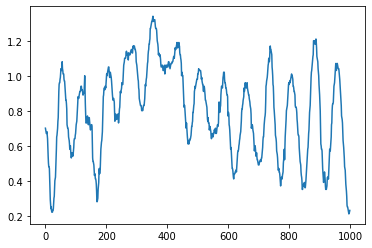

In [5]:
train_df["ssh"].iloc[:1000].plot()

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = 1
hidden_size_TF = 1 
hidden_size = 64
num_epochs = 24
past_len = 800
future_len = 100
batch_size = 32
learning_rate = 1e-3
device

device(type='cpu')

In [8]:
# Here we write a SimpleARModel that uses the network 
# output as the input for the next prediction step (i.e. no teacher forcing)
class SimpleARModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.rnn = nn.GRU(input_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, input_size)

    def forward(self, x, target_seq_len):
        # encoding
        out, h_n = self.rnn(x)
        encoder_out_proj = self.linear(out.reshape(-1, self.hidden_size)).view(
            x.shape[0], -1, self.input_size
        ) # project the output of the encoder to the input size
        inp = encoder_out_proj[:, -1]

        output_seq = torch.empty(
            x.shape[0], target_seq_len, x.shape[-1], device=inp.device
        ) # allocate memory for the output sequence
        output_seq[:, 0] = inp

        for i in range(1,target_seq_len):
            out, h_n = self.rnn(inp.unsqueeze(1), h_n)
            inp = self.linear(out[:, -1])
            output_seq[:, i] = inp
        return encoder_out_proj[:,:-1],output_seq # last decoder proj is the first element of the output_seq


def create_sequences(data, past_len, future_len):
    xs, ys = [], []
    for i in range(past_len, len(data) - future_len):
        x = data[(i - past_len) : i]
        y = data[i : (i + future_len)]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [9]:
# Here we write another class, TeacherForcingModel, that uses the t-1 actual target value as 
# the input for the next prediction step (i.e. teacher forcing) from the second iteration on.
class TeacherForcingModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.step = None
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.rnn = nn.GRU(input_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, input_size)

    def forward(self, x, y,target_seq_len):
        # encoding
        out, h_n = self.rnn(x)
        inp = self.linear(out[:,-1]).unsqueeze(1)

        output_seq = torch.empty(
            x.shape[0], target_seq_len, x.shape[-1], device=inp.device
        ) # allocate memory for the output sequence
         
        for i in range(target_seq_len):
            if i == 0:
                out, h_n = self.rnn(inp, h_n)
                inp = self.linear(out[:,-1].unsqueeze(1))
                output_seq[:, i] = self.linear(out[:,-1])
            else:
                out, h_n = self.rnn(inp, y[:,i-1].unsqueeze(0).contiguous())
                inp = self.linear(out[:,-1].unsqueeze(1))
                output_seq[:, i] = self.linear(out[:,-1])
            
        return output_seq # last decoder proj is the first element of the output_seq

In [10]:
# Here we write another class, TeacherForcingModel, that uses the t-1 actual target value as 
# the input for the next prediction step (i.e. teacher forcing) from the second iteration on. 
# In addition, it´s been used the teacher forcing ratio decreasing during training, also known as dynamic teacher forcing.
# By trial and error and inspired by Gridin, Ivan in "Time Series Forecasting using Deep Learning Combining PyTorch, RNN, TCN, and Deep Neural Network Models to Provide Production-Ready Prediction Solutions" book
# the decreasing ratio was computed randomly according to the number of training steps. 
class TeacherForcingModelBonus(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.step = None
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.rnn = nn.GRU(input_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, input_size)

    def forward(self, x, y,target_seq_len):
        # encoding
        tfr = 0.9
        out, h_n = self.rnn(x)
        inp = self.linear(out[:,-1]).unsqueeze(1)

        output_seq = torch.empty(x.shape[0], target_seq_len, x.shape[-1], device=inp.device) 
         
        for i in range(target_seq_len):
            if i == 0:
                out, h_n = self.rnn(inp, h_n)
                inp = self.linear(out[:,-1].unsqueeze(1))
                output_seq[:, i] = self.linear(out[:,-1])
            else:
                if random.random() < np.maximum((0.9 - (self.step/num_epochs)),0.5):
                    out, h_n = self.rnn(inp, y[:,i-1].unsqueeze(0).contiguous())
                    inp = self.linear(out[:,-1].unsqueeze(1))
                    output_seq[:, i] = self.linear(out[:,-1])
                else:
                    out, h_n = self.rnn(inp, h_n)
                    inp = self.linear(out[:,-1].unsqueeze(1))
                    output_seq[:, i] = self.linear(out[:,-1])
                #if tfr >  0:
                #  tfr = tfr - 0.02
                
        return output_seq # last decoder proj is the first element of the output_seq

In [11]:
train_data = train_df["ssh"].values
test_data = test_df["ssh"].values

X_train, y_train = create_sequences(train_data, past_len, future_len)
X_test, y_test = create_sequences(test_data, past_len, future_len)

X_train = torch.from_numpy(X_train.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [12]:
def run_experiment(model):
    start_time = datetime.datetime.now()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    TFModel = not isinstance(model,SimpleARModel)
    TestLossList = []
    print('Start model training..')
    
    for epoch in range(num_epochs):
        if TFModel:
          model.step = epoch
        model.train()
        for inputs, targets in tqdm(train_dataloader):
            inputs = inputs.unsqueeze(-1).to(device)
            targets = targets.unsqueeze(-1).to(device)
            if TFModel:
                outputs = model(inputs,targets,targets.shape[1])
            else:
                encoder_proj,outputs = model(inputs, targets.shape[1])

            loss = criterion(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        model.eval()
        with torch.no_grad():
            testSumofLoss = 0
            for i, (inputs, targets) in enumerate(tqdm(test_dataloader)):
                inputs = inputs.unsqueeze(-1).to(device)
                targets = targets.unsqueeze(-1).to(device)
                
                if TFModel:
                    outputs = model(inputs, targets,targets.shape[1])
                else:
                    _,outputs = model(inputs, targets.shape[1])
                
                test_loss = criterion(outputs, targets) # but evaluate the model only on decoder outputs
                testSumofLoss += test_loss.item()
                past_view_size = 50
                if i in [0, 1, 2] and (epoch+1) % 3 == 0:
                    inp = inputs[0, :, 0].cpu()
                    tar = targets[0, :, 0].cpu()
                    out = outputs[0, :, 0].cpu()
                    uniplot.plot(
                        ys=[inp[-past_view_size:], tar, out],
                        xs=[
                            np.arange(0, past_view_size),
                            np.arange(past_view_size, past_view_size + len(tar)),
                            np.arange(past_view_size, past_view_size + len(tar)),
                        ],
                        color=True,
                        legend_labels=["Input", "Target", "Output"],
                        title=f"Epoch: {epoch + 1}, Test Loss: {test_loss.item():.4f} - Example {i}",
                        height=10
                    )
        TestLossList.append(testSumofLoss)
    end_time = datetime.datetime.now()
    return end_time - start_time, TestLossList

In [ ]:
lapseofTime, ListofLoss = run_experiment(SimpleARModel(input_size, hidden_size).to(device))

  0%|                                                          | 0/638 [00:00<?, ?it/s]

Start model training..


  1%|▍                                                 | 1/107 [00:00<00:25,  4.23it/s]

           Epoch: 3, Test Loss: 0.0417 - Example 0
┌────────────────────────────────────────────────────────────┐
│▛▚▄▄▄▄▖                     ▟▀▄▞▀▀▄▖                       ▗│ 
││     ▚                   ▄▀▗▀    ▀▝▀▖                   ▗▞▀│ 1
││      ▀▖                ▝ ▞▘       ▚▝▚▖                ▄▀ ▄│ 
││       ▘▖              ▗▘▞          ▝▀▀▖             ▗▞▄▀▀▝│ 
││       ▝▝▄            ▗▗▞             ▚▝▙           ▗▘▝    │ 
││          ▚          ▗▗▞                ▖▀▖       ▗▞▘▘     │ 0
││           ▚         ▗▘                 ▝▀▝▀▄▄ ▗▄▞▀        │ 
││           ▝▖      ▗▞▘                    ▀▀▀▄▀▘▘          │ 
││            ▗▄    ▗▘▀                                      │ 
││              ▀▄▄▄▘                                        │ 
└────────────────────────────────────────────────────────────┘
 0                  50                  100
                          ██ Input
                          ██ Target
                          ██ Output


  2%|▉                                                 | 2/107 [00:00<00:23,  4.50it/s]

           Epoch: 3, Test Loss: 0.0821 - Example 1
┌────────────────────────────────────────────────────────────┐
││               ▄▄▄▄▀▀▄                       ▗▄▀▀▄▄        │ 
││             ▗▀    ▀▄▄▀▄                   ▗▛▘     ▀▚      │ 
││           ▗▀▘       ▝▄▝▚                 ▞▘         ▀▄    │ 1
││           ▝           ▜▄▜▖             ▗▞ ▀▛▀▀▄▖     ▝▚▖  │ 
││         ▗▄▘             ▚▝▚           ▗▌▀▀     ▝▀▀▀▚▄▖ ▝▄ │ 
││         ▄                ▀▝▚▖        ▞▘▖             ▗   ▀│ 
││        ▝                  ▝▀▝▚▄   ▗▄▀▘                ▀▖  │ 0
│▌        ▘                    ▀▄▞▀▀▀▘▀                   ▐▄ │ 
│▗▄    ▗▀▛                                                  ▚│ 
││ ▀▄▄▄▌                                                    ▝│ 
└────────────────────────────────────────────────────────────┘
 0                  50                  100
                          ██ Input
                          ██ Target
                          ██ Output
           Epoch: 3, Test Loss

  4%|█▊                                                | 4/107 [00:00<00:20,  5.06it/s]

┌────────────────────────────────────────────────────────────┐
││ ▄▀▀▀▀▄▖                       ▗▞▀▀▀▀▚▖                    │ 
│▄▞▘     ▀▀▄                    ▞▘      ▝▀▖                  │ 1
││         ▝▄▄                ▗▀▄▄▄▄▖     ▝▚▖              ▗▞│ 
││            ▄              ▐▘▞▘   ▀▀▀▀▄▄▖ ▀▄            ▟▘▘│ 
││             ▀▖           ▞▘            ▀▚  ▚▖        ▗▀▗▘ │ 
││              ▝▄        ▗▞                ▀▖ ▝▚▄    ▄▞▘ ▖  │ 
││                ▀▄▄▄▄▄▗▟▘                  ▝▄   ▀▀▀▀  ▝▀   │ 
││                   ▀▀▀▘                      ▚        ▞    │ 
││▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▚▁▁▁▁▁▗▀▁▁▁▁▁│ 0
││                                               ▚▄▄▄▀▘      │ 
└────────────────────────────────────────────────────────────┘
 0                  50                  100
                          ██ Input
                          ██ Target
                          ██ Output


  1%|▍                                                 | 1/107 [00:00<00:22,  4.71it/s]

           Epoch: 6, Test Loss: 0.0465 - Example 0
┌────────────────────────────────────────────────────────────┐
│▄▄▄▄▄▄▖                     ▄▗▞▀▀▀▀▄                       ▗│ 
││   ▘ ▚                   ▗▞▟▘   ▝▀▌▀▖                   ▗▞▘│ 1
││      ▀                 ▝▗▞       ▝▚▝▄                 ▗▀  │ 
││       ▘▖               ▘▞          ▀▀▙               ▗▘▀▀▀│ 
││       ▝▝▄            ▗▗▞             ▙▚▖            ▗▘    │ 
││          ▄          ▗▘▞               ▝▚▖         ▄▐▘     │ 
││           ▄         ▗▀                 ▝▝▖      ▄▟▄▘      │ 0
││           ▝▖      ▗▄▀                    ▝▚▖▄▄▄▛▄▞        │ 
││            ▗▄    ▗▀▀                       ▝▀▀▀▀          │ 
││             ▝▀▄▄▄▘                                        │ 
└────────────────────────────────────────────────────────────┘
 0                  50                  100
                          ██ Input
                          ██ Target
                          ██ Output
           Epoch: 6, Test Loss

  2%|▉                                                 | 2/107 [00:00<00:22,  4.64it/s]

┌────────────────────────────────────────────────────────────┐
││               ▗▖▗▖▀▚▄                       ▗▞▀▀▀▄▖       │ 
││             ▗▀▘▝▘▝▜▄▝▚▖                    ▞▘     ▝▚      │ 
││           ▗▞▀       ▝▖▐▖                 ▗▞         ▚▖    │ 1
││           ▗          ▝▜▝▄                ▌▄▄▀▄▄▖     ▐▖   │ 
││          ▄▘             ▝▄             ▗▀▀     ▀▀▀▄▄  ▝▄  │ 
││         ▐               ▝▀▚           ▗▌            ▀▚ ▝▄ │ 
││        ▗▘                 ▝▚▖       ▗▄▘              ▝▀▖ ▜│ 0
│▌        ▘                    ▝▙▄▄▄▄▄▗▄▘                 ▐▄ │ 
│▗▄    ▗▀▞                       ▀▙▄▄▞▘                     ▚│ 
││ ▀▄▄▄▌                                                    ▝│ 
└────────────────────────────────────────────────────────────┘
 0                  50                  100
                          ██ Input
                          ██ Target
                          ██ Output
           Epoch: 6, Test Loss: 0.0585 - Example 2


  4%|█▊                                                | 4/107 [00:00<00:20,  5.15it/s]

┌────────────────────────────────────────────────────────────┐
││ ▄▞▀▀▚▄                        ▗▞▀▀▀▀▚▖                    │ 
│▄▞▘     ▀▀▖                    ▞▘      ▝▚▖                  │ 1
│▘         ▝▄▄                 ▞▘▖▄▄▖     ▚▖                ▗│ 
││           ▝▖              ▗▀▄▘▝  ▀▀▀▀▄▄ ▝▌              ▄▘│ 
││            ▝▜            ▗▀            ▀▚▝▚            ▟▘ │ 
││              ▀▄        ▗▗▘               ▚ ▚▖        ▗▞▞  │ 
││                ▀▄▄▄▄▄▄▗▞▘                 ▀▖▝▙▖     ▄▀▀   │ 
││                   ▄ ▄▄▀                    ▝▚ ▝▚▄▄▞▀ ▞    │ 
││▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▝▀▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▚▁▁▁▁▁▗▀▁▁▁▁▁│ 0
││                                               ▚▄▄▄▀▘      │ 
└────────────────────────────────────────────────────────────┘
 0                  50                  100
                          ██ Input
                          ██ Target
                          ██ Output


 71%|█████████████████████████████████▊              | 450/638 [04:42<01:55,  1.63it/s]

In [27]:
lapseofTimeTF, ListofLossTF = run_experiment(TeacherForcingModel(input_size, hidden_size_TF).to(device))

Start model training..


  2%|▏         | 2/107 [00:00<00:07, 14.83it/s]

           Epoch: 3, Test Loss: 0.0124 - Example 0
┌────────────────────────────────────────────────────────────┐
│▛▚▄▄▄▄▖                     ▟▀▀▀▀▄                          │ 
││     ▚                   ▄▀▄▄▄▄▚▄▄▖                        │ 1
││      ▀▖                ▗▀▀       ▝▀▄                   ▗ ▄│ 
││       ▘▖              ▗▖           ▝▀▌               ▗▄▀▀▝│ 
││       ▝▝▄            ▗▘              ▝▀▘           ▐▄▘    │ 
││          ▚          ▗▘                 ▀▄▖       ▗▀▘▘     │ 0
││           ▚         ▝                  ▝▀▀▄▄▄▄ ▄▀▀        │ 
││           ▝▖      ▝▄▖                    ▀▀▀▄▘▀▘          │ 
││            ▗▄    ▗▖▀                                      │ 
││              ▀▄▄▄▘                                        │ 
└────────────────────────────────────────────────────────────┘
 0                  50                  100
                          ██ Input
                          ██ Target
                          ██ Output
           Epoch: 3, Test Loss

  4%|▎         | 4/107 [00:00<00:05, 17.64it/s]

           Epoch: 6, Test Loss: 0.0025 - Example 0
┌────────────────────────────────────────────────────────────┐
│▛▚▄▄▄▄▖                     ▟▀▀▀▀▙▖                         │ 
││     ▚                   ▄▞      ▝▀▖                       │ 1
││      ▀▖                ▗          ▝▖                   ▗ ▄│ 
││       ▘▖              ▗▖           ▝▀▘               ▗▄▞▀▝│ 
││       ▝▝▄            ▗▜              ▚▄            ▗▗▀    │ 
││          ▚          ▗▀                 ▚          ▗▄▀     │ 0
││           ▄         ▝                  ▘▞▘      ▄▟▘       │ 
││           ▝▖      ▗▗▘                    ▀▀▀▄▙▄▛          │ 
││            ▗▄    ▗▘▖▘                                     │ 
││              ▀▄▄▄▘                                        │ 
└────────────────────────────────────────────────────────────┘
 0                  50                  100
                          ██ Input
                          ██ Target
                          ██ Output
           Epoch: 6, Test Loss

  4%|▎         | 4/107 [00:00<00:06, 17.13it/s]

           Epoch: 9, Test Loss: 0.0022 - Example 0
┌────────────────────────────────────────────────────────────┐
│▄▚▄▄▄▄▖                     ▐▀▀▀▀▙                          │ 
││   ▘ ▚                   ▗▞▘    ▝▀▚                        │ 1
││      ▀                 ▝▘         ▀▖                   ▗ ▖│ 
││       ▘▖              ▗▘           ▀▀▖               ▖▗▞▚▝│ 
││       ▝▝▄            ▗▘▘             ▄▖            ▗▖▝▘   │ 
││          ▚          ▗▚▝               ▝▚▗         ▗▖▗     │ 0
││           ▄         ▗                  ▘▖▖      ▄▟▘▝      │ 
││           ▝▖      ▗▗▘                    ▀▚▀▄▙▄▛          │ 
││            ▗▄    ▗▘▖▘                                     │ 
││             ▝▀▄▄▄▘                                        │ 
└────────────────────────────────────────────────────────────┘
 0                  50                  100
                          ██ Input
                          ██ Target
                          ██ Output
           Epoch: 9, Test Loss

  2%|▏         | 2/107 [00:00<00:06, 15.08it/s]

           Epoch: 12, Test Loss: 0.0021 - Example 0
┌────────────────────────────────────────────────────────────┐
│▞▚▄▄▄▄▖                     ▐▀▀▀▀▙                          │ 
││     ▚                   ▗▞▘    ▝▀▚                        │ 1
││      ▀                 ▝▘         ▀▖                   ▗ ▖│ 
││       ▘▖              ▄▘           ▝▀▖               ▖▗▞▚▝│ 
││       ▝▝▄            ▖▞▘             ▄▄            ▗▖▝▘   │ 
││          ▚          ▗▗▝                ▚▗         ▗▄▗     │ 0
││           ▄         ▗                  ▘▖▖      ▄▟▘       │ 
││           ▝▖      ▄▗▘                    ▀▚▀▄▙▄▛          │ 
││            ▗▄    ▗▚▖▘                                     │ 
││             ▝▀▄▄▄▘                                        │ 
└────────────────────────────────────────────────────────────┘
 0                  50                  100
                          ██ Input
                          ██ Target
                          ██ Output
           Epoch: 12, Test Lo

  4%|▎         | 4/107 [00:00<00:06, 17.13it/s]

           Epoch: 15, Test Loss: 0.0018 - Example 0
┌────────────────────────────────────────────────────────────┐
│▞▚▄▄▄▄▖                     ▐▀▀▀▀▙                          │ 
││     ▚                   ▗▞▘    ▝▀▚                        │ 1
││      ▀                 ▝▀         ▀▖                   ▗ ▖│ 
││       ▘▖              ▄▘           ▝▀▘               ▖▗▞▚▝│ 
││       ▝▝▄            ▖▀▘             ▄▄            ▗▖▝▘   │ 
││          ▚          ▗▗▝                ▚▗         ▗▄▗     │ 0
││           ▄         ▗                  ▘▖▖      ▄▟▘       │ 
││           ▝▖      ▗▗▘                    ▀▚▀▄▙▄▛          │ 
││            ▗▄    ▗▀▖▘                                     │ 
││             ▝▀▄▄▄▘                                        │ 
└────────────────────────────────────────────────────────────┘
 0                  50                  100
                          ██ Input
                          ██ Target
                          ██ Output
           Epoch: 15, Test Lo

  2%|▏         | 2/107 [00:00<00:07, 13.46it/s]

           Epoch: 18, Test Loss: 0.0016 - Example 0
┌────────────────────────────────────────────────────────────┐
│▞▚▄▄▄▄▖                     ▐▀▀▀▀▙                          │ 
││     ▚                   ▗▞▘    ▝▀▚                        │ 1
││      ▀▖                ▝▀         ▀▖                   ▗ ▖│ 
││       ▘▖              ▄▘           ▝▀▘               ▖▗▞▚▝│ 
││       ▝▝▄            ▖▗▘             ▚▄            ▗▖▝▘   │ 
││          ▚          ▗▗                 ▚▗         ▗▄▗     │ 0
││           ▄         ▗                  ▘▖▖      ▄▟▘       │ 
││           ▝▖      ▝ ▘                    ▀▄▛▄▙▄▛          │ 
││            ▗▄    ▗▞▀▘                                     │ 
││             ▝▀▄▄▄▘                                        │ 
└────────────────────────────────────────────────────────────┘
 0                  50                  100
                          ██ Input
                          ██ Target
                          ██ Output
           Epoch: 18, Test Lo

  4%|▎         | 4/107 [00:00<00:05, 18.14it/s]

           Epoch: 21, Test Loss: 0.0016 - Example 0
┌────────────────────────────────────────────────────────────┐
│▞▚▄▄▄▄▖                     ▐▀▀▀▀▙                          │ 
││     ▚                   ▗▞▘    ▝▀▚                        │ 1
││      ▀▖                ▝▀         ▀▖                   ▗ ▖│ 
││       ▘▖              ▄▘           ▝▀▘               ▖▗▞▚▝│ 
││       ▝▝▄            ▖▗▘             ▚▄            ▝▖▝▘   │ 
││          ▚          ▗▗                 ▚▗         ▗▄▗     │ 0
││           ▄         ▗                  ▘▖▖      ▄▟▘       │ 
││           ▝▖      ▝ ▘                    ▀▀▀▄▙▄▛          │ 
││            ▗▄    ▗▞▀▘                                     │ 
││             ▝▀▄▄▄▘                                        │ 
└────────────────────────────────────────────────────────────┘
 0                  50                  100
                          ██ Input
                          ██ Target
                          ██ Output
           Epoch: 21, Test Lo

  4%|▎         | 4/107 [00:00<00:06, 16.80it/s]

           Epoch: 24, Test Loss: 0.0015 - Example 0
┌────────────────────────────────────────────────────────────┐
│▞▚▄▄▄▄▖                     ▐▀▀▀▀▙                          │ 
││     ▚                   ▗▞▘    ▝▀▚                        │ 1
││      ▀▖                ▝▘         ▀▖                   ▗ ▄│ 
││       ▘▖              ▄▘           ▝▀▘               ▖▗▞▚▝│ 
││       ▝▝▄            ▖▗▘             ▚▄            ▝▖▝▘   │ 
││          ▚          ▗▗                 ▚▗         ▗▄▗     │ 0
││           ▄         ▗                  ▘▖▖      ▄▟▘       │ 
││           ▝▖      ▝ ▘                    ▀▀▀▄▙▄▛          │ 
││            ▗▄    ▗▞▀▘                                     │ 
││             ▝▀▄▄▄▘                                        │ 
└────────────────────────────────────────────────────────────┘
 0                  50                  100
                          ██ Input
                          ██ Target
                          ██ Output
           Epoch: 24, Test Lo

100%|██████████| 107/107 [00:03<00:00, 28.03it/s]


In [28]:
lapseofTimeBonus, ListofLossBonus = run_experiment(TeacherForcingModelBonus(input_size, hidden_size_TF).to(device))

Start model training..


  4%|▎         | 4/107 [00:00<00:05, 17.23it/s]

           Epoch: 3, Test Loss: 0.0041 - Example 0
┌────────────────────────────────────────────────────────────┐
│▛▚▄▄▄▄▖                     ▗▞▀▛▀▄                          │ 
││     ▚                   ▗▄▘     ▀▚▖                       │ 1
││      ▀▖                ▝▘         ▝▄                   ▗▖▗│ 
││       ▘▖              ▗▄           ▝▀▌               ▗▄▞▝▘│ 
││       ▝▝▄            ▗▀              ▝▀▖           ▗▄▘    │ 
││          ▚          ▗▖                 ▝▄▖       ▗▄▘▘     │ 0
││           ▚       ▘ ▗                  ▝▀▚▄▄▖▖ ▄▀▀        │ 
││           ▝▖      ▝▄▘                    ▀▀▀▝▀▀▘          │ 
││            ▗▄    ▗▝▀                                      │ 
││              ▀▄▄▄▘                                        │ 
└────────────────────────────────────────────────────────────┘
 0                  50                  100
                          ██ Input
                          ██ Target
                          ██ Output
           Epoch: 3, Test Loss

  4%|▎         | 4/107 [00:00<00:05, 17.17it/s]

           Epoch: 6, Test Loss: 0.0060 - Example 0
┌────────────────────────────────────────────────────────────┐
│▛▚▄▄▄▄▖                     ▗▞▀▀▀▚▖                         │ 
││     ▚                   ▗▀▘     ▝▀▖                       │ 1
││      ▀▖                ▝▘▀        ▝▄                   ▗ ▄│ 
││       ▘▖              ▗▞           ▝▀▙               ▗▄▞▀▝│ 
││       ▝▝▄            ▗▟              ▚▞▖           ▗▗▖    │ 
││          ▚          ▗▞                 ▞          ▗▞▀     │ 0
││           ▚       ▗ ▝                  ▝▀▌     ▗▄▟▘       │ 
││           ▝▖      ▘ ▝                    ▝▀▀▚▞▄▀          │ 
││            ▗▄    ▗▝▀▘                                     │ 
││              ▀▄▄▄▘                                        │ 
└────────────────────────────────────────────────────────────┘
 0                  50                  100
                          ██ Input
                          ██ Target
                          ██ Output
           Epoch: 6, Test Loss

  2%|▏         | 2/107 [00:00<00:09, 11.03it/s]

           Epoch: 9, Test Loss: 0.0058 - Example 0
┌────────────────────────────────────────────────────────────┐
│▛▚▄▄▄▄▖                     ▗▀▀▀▀▙▄                         │ 
││     ▚                   ▄▄▖     ▀▀▖                       │ 1
││      ▀▖                ▝▀         ▝▄                     ▗│ 
││       ▘▖              ▗▄           ▝▀▘               ▗▄▞▀▘│ 
││       ▝▝▄            ▗▐              ▝▄▄            ▗▞    │ 
││          ▚          ▗▘                 ▖          ▗▞▀     │ 0
││           ▄         ▝▄▖                ▝▀▙      ▗▟▘       │ 
││           ▝▖      ▀ ▝                    ▀▀▀▚▄▄▛▘         │ 
││            ▗▄    ▗▚▚▘                                     │ 
││              ▀▄▄▄▘                                        │ 
└────────────────────────────────────────────────────────────┘
 0                  50                  100
                          ██ Input
                          ██ Target
                          ██ Output
           Epoch: 9, Test Loss

  7%|▋         | 7/107 [00:00<00:06, 16.32it/s]

┌────────────────────────────────────────────────────────────┐
││ ▞▀▀▀▀▚▄                                                   │ 
│▄▞       ▀▄                                                 │ 1
││         ▝▚▄                  ▄▄▞▄▄▄                      ▗│ 
││            ▚               ▗▞▀▀   ▝▀▀▚▄▀▖▖              ▗▄│ 
││             ▀▖    ▀     ▗▞▄▘           ▀▝▘             ▗▘ │ 
││              ▝▀▖      ▗▗▟                ▝▚▖          ▗▄▞ │ 
││                ▝▚▀▗▄▀▚▀▘                  ▝▄▖        ▝▝   │ 
││                                             ▝▖      ▗▗▘   │ 
││▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▝▘▖▁▁▁▗▞▘▁▁▁▁│ 0
││                                               ▝▚▄▄▄▀      │ 
└────────────────────────────────────────────────────────────┘
 0                  50                  100
                          ██ Input
                          ██ Target
                          ██ Output


  4%|▎         | 4/107 [00:00<00:05, 17.77it/s]

           Epoch: 12, Test Loss: 0.0055 - Example 0
┌────────────────────────────────────────────────────────────┐
│▛▚▄▄▄▄▖                     ▐▀▀▀▀▚▄                         │ 
││     ▚                   ▗▞▘     ▀▀▄                       │ 1
││      ▀▖                ▝          ▚▄▖                    ▗│ 
││       ▘▖              ▗▞▘          ▝▝▘               ▖▄▄▀▀│ 
││       ▝▝▄            ▗▝              ▝▀▖            ▗▝    │ 
││          ▚          ▗▄▀                ▗▖▗▖       ▄▟▀▀    │ 0
││           ▚         ▝                  ▝▝▘     ▗▗▟▀       │ 
││           ▝▖      ▄▖▝                    ▀▝▀▚▄▄▞▘         │ 
││            ▗▄    ▗▝▝▘                                     │ 
││              ▀▄▄▄▘                                        │ 
└────────────────────────────────────────────────────────────┘
 0                  50                  100
                          ██ Input
                          ██ Target
                          ██ Output
           Epoch: 12, Test Lo

  4%|▎         | 4/107 [00:00<00:05, 17.63it/s]

           Epoch: 15, Test Loss: 0.0062 - Example 0
┌────────────────────────────────────────────────────────────┐
│▛▚▄▄▄▄▖                     ▗▀▞▀▀▙▖                         │ 
││     ▚                   ▄▀▀     ▝▀▘                       │ 1
││      ▀▖                ▝          ▝▄                     ▗│ 
││       ▘▖              ▗▘           ▝▀▀               ▖▗▞▀▘│ 
││       ▝▝▄            ▗▄▀▀▀           ▚▞▖            ▗▝▘   │ 
││          ▚          ▗▄                 ▗ ▄        ▗▞▀▀    │ 0
││           ▄         ▝                  ▝▀▖   ▗  ▄▄▘       │ 
││           ▝▖      ▗▖▝                    ▀▚▀▞▘▄▛▀         │ 
││            ▗▄    ▗▀▝▘                                     │ 
││              ▀▄▄▄▘                                        │ 
└────────────────────────────────────────────────────────────┘
 0                  50                  100
                          ██ Input
                          ██ Target
                          ██ Output
           Epoch: 15, Test Lo

  1%|          | 1/107 [00:00<00:11,  9.52it/s]

           Epoch: 18, Test Loss: 0.0056 - Example 0
┌────────────────────────────────────────────────────────────┐
│▛▚▄▄▄▄▖                     ▗▀▀▀▀▚▖                         │ 
││     ▚                   ▗▄▘     ▝▀▚▖                      │ 1
││      ▀▖                ▝          ▚▗                    ▗▄│ 
││       ▘▖              ▗▝▘          ▝▀▙               ▖▗▞▘▝│ 
││       ▝▝▄            ▗▞▘             ▚▞▘            ▄▞▘   │ 
││          ▚          ▗▝                 ▗▖▄        ▗▞▘     │ 0
││           ▚         ▝▘                 ▝▝▘     ▗▄▗▘       │ 
││           ▝▖      ▄▄▝                    ▀▀▛▀▄▄▞▀▘        │ 
││            ▗▄    ▗▀▀▘                                     │ 
││              ▀▄▄▄▘                                        │ 
└────────────────────────────────────────────────────────────┘
 0                  50                  100
                          ██ Input
                          ██ Target
                          ██ Output
           Epoch: 18, Test Lo

  6%|▌         | 6/107 [00:00<00:06, 15.42it/s]

┌────────────────────────────────────────────────────────────┐
││ ▞▀▀▀▀▚▄                                                   │ 
│▄▞       ▀▄                                                 │ 1
││         ▝▚▄                  ▗▄▄▄▄▄▖                     ▗│ 
││            ▚               ▚▗▘    ▀▀▀▚▄▄▄               ▗▝│ 
││             ▀▖           ▚▄▀▘          ▀▚▖             ▗▄▖│ 
││              ▝▜   ▘    ▄▄▄               ▀▀▘          ▗▗  │ 
││                ▀▄▄▗▄▄▄▟▀                  ▝▄▖▖       ▝▘▘  │ 
││                                             ▝▘▗▖    ▗▗▄   │ 
││▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▝▘▁▁▁▁▗▄▀▁▁▁▁│ 0
││                                               ▚▞▄▟▄▀      │ 
└────────────────────────────────────────────────────────────┘
 0                  50                  100
                          ██ Input
                          ██ Target
                          ██ Output


  4%|▎         | 4/107 [00:00<00:06, 16.78it/s]

           Epoch: 21, Test Loss: 0.0086 - Example 0
┌────────────────────────────────────────────────────────────┐
│▛▚▄▄▄▄▖                     ▗▀▄▛▀▚▄                         │ 
││     ▚                   ▗▄▖     ▀▀▖                       │ 1
││      ▀▖                ▝▀         ▝▄                   ▗▖▄│ 
││       ▘▖              ▗▞           ▝▀▌               ▗▄▞▝▝│ 
││       ▝▝▄            ▗▟              ▝▀▘            ▗▝    │ 
││          ▚          ▗▘                 ▚ ▖        ▗▟▀▘    │ 0
││           ▚         ▗▀                 ▝▀▖▄    ▗▗▄▘       │ 
││           ▝▖      ▄▄                     ▝▀▀▞▚▄▛▘         │ 
││            ▗▄    ▗▀▀▀                                     │ 
││              ▀▄▄▄▘                                        │ 
└────────────────────────────────────────────────────────────┘
 0                  50                  100
                          ██ Input
                          ██ Target
                          ██ Output
           Epoch: 21, Test Lo

  2%|▏         | 2/107 [00:00<00:06, 15.52it/s]

           Epoch: 24, Test Loss: 0.0057 - Example 0
┌────────────────────────────────────────────────────────────┐
│▛▚▄▄▄▄▖                     ▝▄▄▀▀▚▖                         │ 
││     ▚                   ▗▝▀     ▝▀▄                       │ 1
││      ▀▖                ▝▝▘        ▚▄▖                   ▄▄│ 
││       ▘▖              ▗▄▖          ▝▝▀▘              ▖▄▟▀▝│ 
││       ▝▝▄            ▗▄              ▚▗▖            ▗▟    │ 
││          ▚          ▗▝                 ▞          ▗▟▀     │ 0
││           ▚         ▞▘                 ▝▀▘▄    ▗▗▄▘       │ 
││           ▝▖      ▄▖                     ▝▀▀▚▄▞▞▘         │ 
││            ▗▄    ▗▀▝▀                                     │ 
││              ▀▄▄▄▘                                        │ 
└────────────────────────────────────────────────────────────┘
 0                  50                  100
                          ██ Input
                          ██ Target
                          ██ Output
           Epoch: 24, Test Lo

100%|██████████| 107/107 [00:03<00:00, 29.15it/s]


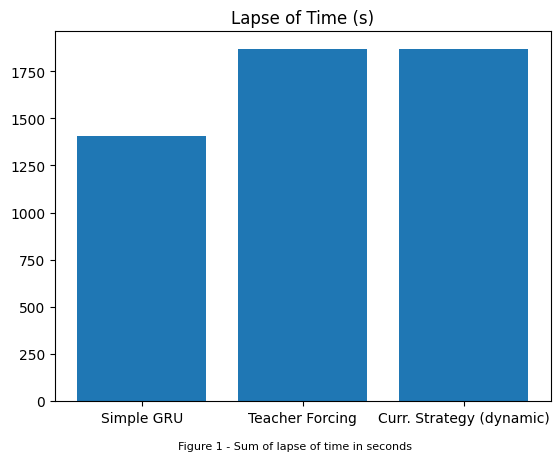

In [46]:
import matplotlib.pyplot as plt
x = np.array(["Simple GRU", "Teacher Forcing", "Curr. Strategy (dynamic)"])
y = np.array([lapseofTime.total_seconds(),lapseofTimeTF.total_seconds(), lapseofTimeBonus.total_seconds()])
plt.title('Lapse of Time (s)')
plt.figtext(0.5, 0.01, "Figure 1 - Sum of lapse of time in seconds", ha="center", fontsize=8)
plt.bar(x,y)
plt.show()

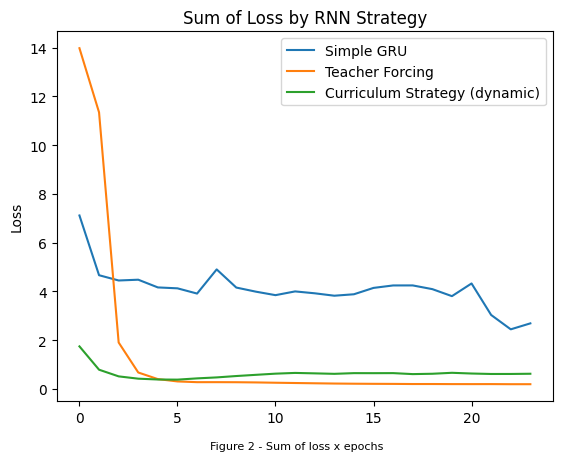

In [47]:
x_axis = [i for i in range(num_epochs)]
y_curriculum = ListofLoss
y_curriculum2 = ListofLossTF
y_curriculum3 = ListofLossBonus
plt.plot(x_axis, y_curriculum, label = "Simple GRU")
plt.plot(x_axis, y_curriculum2, label = "Teacher Forcing")
plt.plot(x_axis, y_curriculum3, label = "Curriculum Strategy (dynamic)")
plt.title('Sum of Loss by RNN Strategy')
#plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.figtext(0.5, 0.01, "Figure 2 - Sum of loss x epochs", ha="center", fontsize=8)
plt.legend()
plt.show()

# The Challenge of Long-Term Dependencies

The basic problem is that gradients propagated over many stages tend to either vanish (most of the time) or explode (rarely, but with much damage to the optimization).

Recurrent networks involve the composition of the same function multiple times, once per time step.

In particular, the function composition employed by recurrent neural networks somewhat resembles matrix multiplication. We can think of the recurrence relation:

$h^{(t)} = W^Th^{(t-1)}$

as a very simple recurrent neural network lacking a nonlinear activation function and lacking inputs x. 
This recurrence relation essentially describes the power method. It may be simpliﬁed to:

$h^{(t)} = (W^t)^Th^{(0)}$

and if W admits an eigendecomposition of the form:

$W = Q \Lambda Q^T$

with orthogonal Q, the recurrence may be simpliﬁed further to:

$h^{(t)} = Q^T \Lambda^{t} Q h^{(0)}$

The eigenvalues are raised to the power of t, causing eigenvalues with magnitude less than one to decay to zero and eigenvalues with magnitude greater than one to explode. Any component of $h(0)$ that is not aligned with the largest eigenvector will eventually be discarded.

Several approaches have been proposed to tackle this. Namely:
- Adding Skip Connections through Time: One way to obtain coarse time scales is to add direct connections from variables in the distant past to variables in the present.
- Adding other controlled gates: This allows the network to accumulate information (such as evidence for a particular feature or category) over a long duration. Once that information has been used, however, it might be useful for the neural network to forget the old state.
- Gradient clipping: Prevents gradient explosion
- Many others...

# Exercise
A more comprehensive look into sequence modeling can be found at: https://www.deeplearningbook.org/contents/rnn.html

One of the strategies to train RNNs is called teacher forcing. This strategy allows for the network to use the actual label instead of its generated output as input to the next step. This allows for the gradient to be propagated through fewer steps in some networks and also for the network to slowly be able to use its own outputs.

Exercise:
Implement the **teacher forcing** mechanism and compare the results.

## Answer

### **Introduction**: 
- RNNs are a class of neural network designed to __process sequence of related data__ by allowing previous output to be used as inputs while having hidden states. 
- As main __advantages__ they are capable of process input of any length, model size does not increase with the size of input, computation takes into account historical information and weights are shared across time. 
- However computation may be __slow and they have difficulty of accessing information from a long time ago__, also known as the vanishing gradient problem. Thus GRU and LSTM architectures are used to handle these issues.

### **The Problem**: 
- In our example a special kind of RNN architecture called GRU, was used to predict the sea surface height (SSH) based on measurements extracted from the Santos Port Channel dataset.
- The GRU is an advanced version of the classical RNN, as well as LSTM achitecture. Their primary purpose is to store long-term information.
- In order to improve RNN performance __teacher forcing__ mechanism was used. It is one of the strategies used to train the so-called Encoder-Decoder model which is a logial continuation of RNN model and they have provided the state-of-the-art results in sequence-to-sequence multistep time series forecasting.
- In addition, as bonus activity, it was required an approach that decreases the teacher forcing ratio as the training progresses, which is known as __curriculum strategy__.

### **More about _Teacher Forcing_**: 
- Teacher forcing training adds external information to the training before loss calculation.
- During teacher forcing training, the decoder RNN cell receives actual previous target values on each step, as shown in figure below:

<img src='https://drive.google.com/uc?id=1wksfIrXGPgCyrkIyGJFAX3X16T3QMz_t' width="50%" height="50%">

### **The Implementation**: 

- As RNN cell will be feed by actual previous target values to training, hidden_size parameter must to be equal to **1** (target dimension) instead of 64 and thus it was created another parameter called **hidden_size_TF** to be used with teacher forcing implementations.

- The number of epochs for training purpose was increased from 15 to 24 (num_epochs = 24);

- Two new classes, **TeacherForcingModel** and **TeacherForcingModelBonus** were created;

- **TeacherForcingModel** uses the t-1 actual target value as the input for the next prediction step (i.e. teacher forcing) from the second iteration on. _Forward_ method requires target values (y) as additional parameter; 

- **TeacherForcingModelBonus** implementation is similar to the first one, however it implements teacher forcing ratio decreasing during training, also known as dynamic teacher forcing. By trial and error and inspired by Gridin, Ivan in "_Time Series Forecasting using Deep Learning Combining PyTorch, RNN, TCN, and Deep Neural Network Models to Provide Production-Ready Prediction Solutions_" book, the decreasing ratio was computed randomly according to the number of training steps or epochs;

- Finally, **run_experiment** class was created to ease three scenarios execution used in this experiment - Simple GRU, Teacher Forcing and the curriculum strategy, in fact, the dynamic curriculum strategy;

- Two metrics were computed in all of the scenarios overall execution lapse of time and the sum of test loss.

### **The Scenarios**: 
- The teacher forcing, teacher forcing bonus as well as the classical GRU model were performed locally, at mini-conda and Google Colab environments, but final results were colleted by Colab environment.
- In order to measure performance three metrics were used: overall execution lapse of time and the sum of test loss and time-to-fit.

### **Results**: 
- As expected, teacher forcing approach improved network performance when compared with simple GRU RNN.

- Regarding the proposed metrics it is possible to notice that:
  - Computed overall execution lapse of time shows that simple GRU runs slightly faster than teacher forcing implementation, as we can see in Figure 1. It may be explained as it is computationally simpler than the other approachs. 
  - As expected test loss was better by the use of _Teacher Forcing_ approaching than without it. However the simple use of it, when target values are used for training, the model lacks generalization, due to bias.
  - When _Teacher Forcing_ was improved by the dinamic curriculum strategy was used we notice faster fitting as epochs pass by. In addition, as there are both target and predicted values as part of training, it tends to reduce overfitting. See Figure 2.
  - And last, but not least, by visual inspection we notice that with the use of teacher forcing since the first epochs the model outputs shapes of actual values, on the other hand without it, the model takes much longer to do it. See trainning and evaluation charts as well as figure 2.

### **References:**

- Article: The Unreasonable Effectiveness of Recurrent Neural Networks, available at: https://karpathy.github.io/2015/05/21/rnn-effectiveness/
- Book: Deep Learning, provided by MIT, available at: https://www.deeplearningbook.org/
- Book: Time Series Forecasting using Deep Learning: Combining PyTorch, RNN, TCN, and Deep Neural Network Models to Provide Production-Ready Prediction Solutions (English Edition)
- PyTorch Tutorial, by Patrick Loeber, available at: https://www.youtube.com/watch?v=EMXfZB8FVUA&list=PLqnslRFeH2UrcDBWF5mfPGpqQDSta6VK4